In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.autograd as autograd
import torch.nn.functional as F

# Make data

In [2]:
x = np.linspace(-3, 3, 300)
x_ = np.linspace(-3,3, 300)

In [3]:
y = x**2 + 3 *np.random.uniform(size=x.size)
# y = x**2 + 3* (x-2) *np.random.uniform(size=x.size)
y_ = -x_**2 + 3*np.random.uniform(size=x_.size)

In [4]:
# x = np.concatenate([x,x_])
# y = np.concatenate([y,y_])

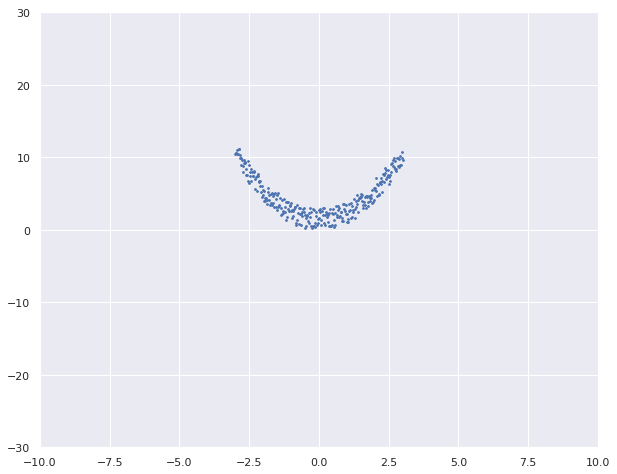

In [5]:
plt.figure(figsize=(10,8))
plt.xlim(-10,10)
plt.ylim(-30,30)
plt.scatter(x, y,s=3)

# Define nets(particles)

In [6]:
class Net(nn.Module):
    def __init__(self,hidden_size=20):
        super().__init__()
        self.fc1 = nn.Linear(1,hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)
        self.fc1.weight.data.normal_(0,0.01)
        nn.init.constant_(self.fc1.bias, 0.0)
        self.fc2.weight.data.normal_(0,0.01)
        nn.init.constant_(self.fc2.bias, 0.0)
        self.out.weight.data.normal_(0,0.01)
        nn.init.constant_(self.out.bias, 0.0)
        
    def forward(self, input):
        input = input.view(-1,1)
        x = F.relu(self.fc1(input))
        x = F.relu(self.fc2(x))
        out = self.out(x)
        return out

In [7]:
num_nets = 10
nets = [Net() for i in range(num_nets)]
nets_old = [Net() for i in range(num_nets)]

def renew_old():
    for i in range(num_nets):
        nets_old[i].load_state_dict(nets[i].state_dict())
        
renew_old()

# Calculate the Stein Variational Gradient

In [8]:
def rbf_kernel(net1, net2, h=2):
    sse = 0.
    for net1_param, net2_param in zip(net1.parameters(), net2.parameters()):
        sse = sse + torch.sum((net1_param-net2_param)**2)
    return torch.exp(-sse/h)

def eval_svgd(net, input, target, lr=1e-3):
    grads = []
    for i in range(num_nets):
        score = 0.
        score = (-(nets_old[i](input).view(-1)- target)**2).sum()
        kernel = rbf_kernel(net, nets_old[i])
        
        grads_score = autograd.grad(score, nets_old[i].parameters())
        grads_kernel = autograd.grad(kernel, nets_old[i].parameters())
        grad = ((kernel*grad_score + grad_kernel)/num_nets \
                for grad_score, grad_kernel in zip(grads_score, grads_kernel))
        grads.append(grad)
    
    for grad in grads:
        for param, param_grad in zip(net.parameters(), grad):
            param.data.copy_(param.data + lr*param_grad)

# Test it!

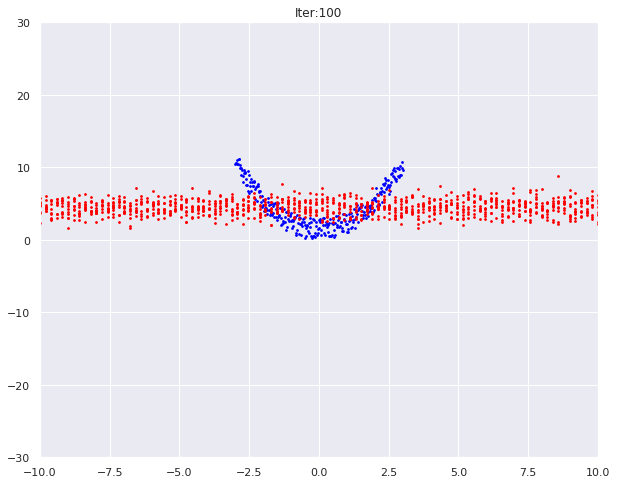

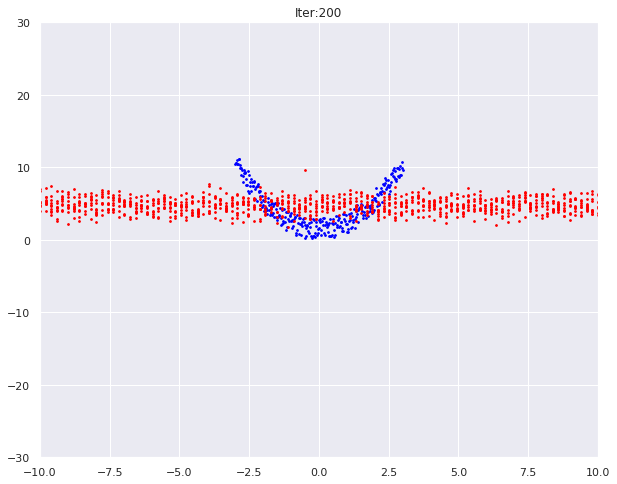

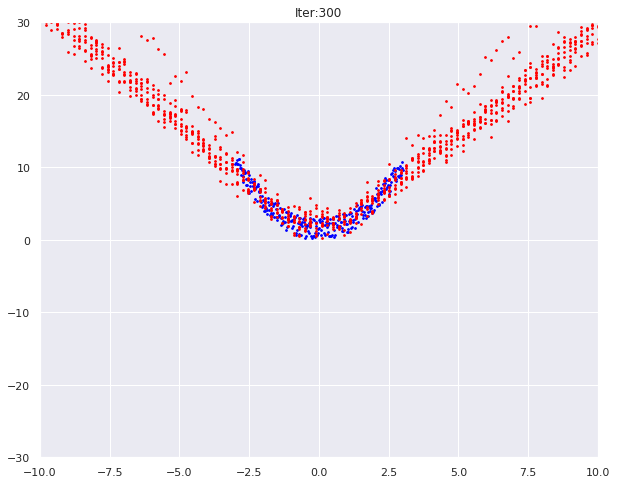

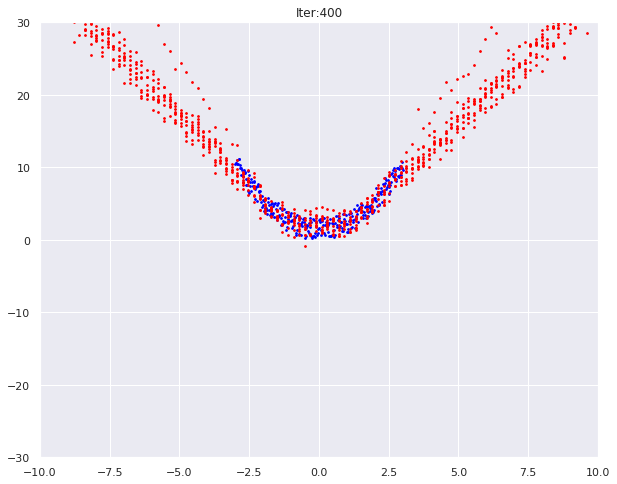

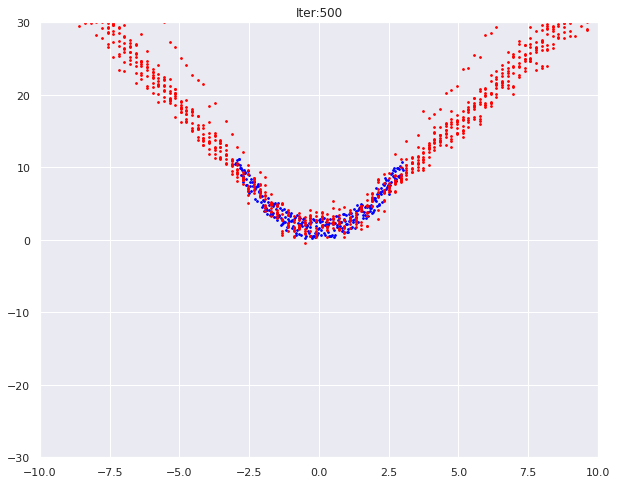

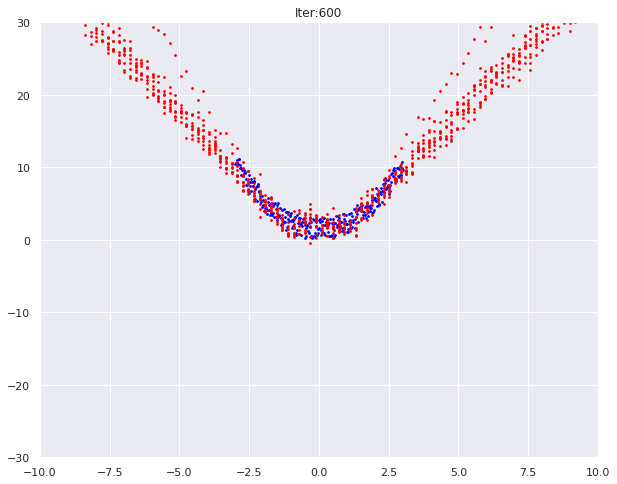

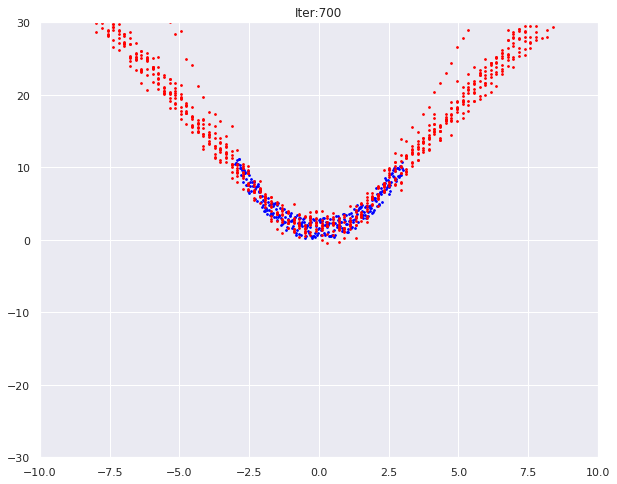

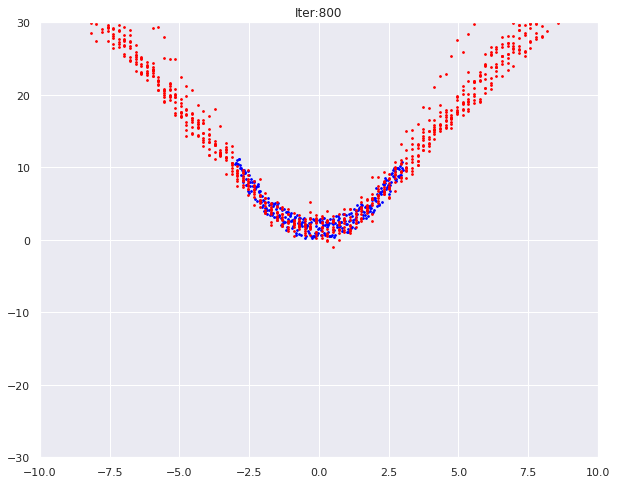

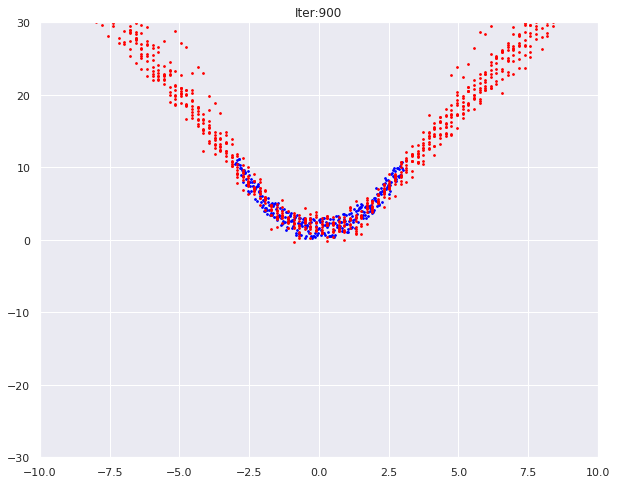

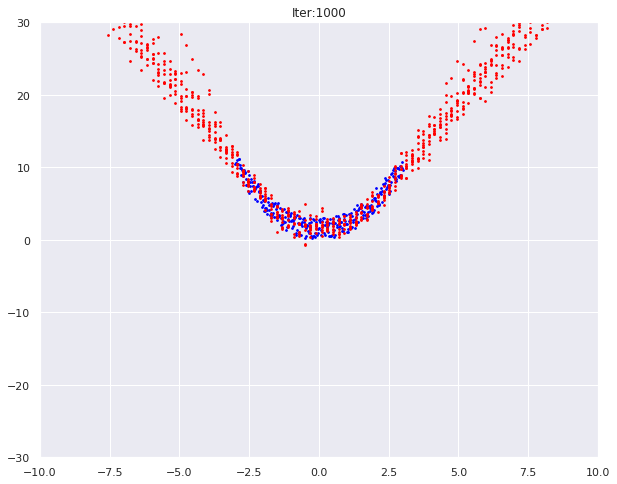

In [9]:
ITER_NUM = int(1e3)
BATCH_SIZE = 32
IMAGE_SHOW = 100

for i in range(ITER_NUM):
    # sample minibatch
    index = np.random.choice(range(len(x)), size=BATCH_SIZE)
    mini_x = Variable(torch.FloatTensor(x[index]))
    mini_y = Variable(torch.FloatTensor(y[index]))
    
    # eval_svgd
    for j in range(num_nets):
        eval_svgd(nets[j], mini_x, mini_y)
    renew_old()
    
    if (i+1)%IMAGE_SHOW == 0:
        plt.rcParams["figure.figsize"] = (10,8)
        fig, ax = plt.subplots()
        plt.xlim(-10,10)
        plt.ylim(-30,30)
        x_test = Variable(torch.FloatTensor(np.linspace(-10,10, 100)))
        predict = np.zeros((num_nets,100))
        ax.scatter(x, y,s=3,color='blue')
        for k in range(num_nets):
            predict[k] = nets[k](x_test).detach().numpy().reshape(-1)+np.random.normal(size=100)
        ax.scatter(list(np.linspace(-10,10, 100))*num_nets, predict.reshape(-1),s=3,color='red')
        ax.set_title('Iter:'+str(i+1))
        plt.show()